In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.optimizers import SGD,Adam 
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.callbacks import ModelCheckpoint 
import cv2
import tensorflow as tf
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
import zipfile
from keras.preprocessing import image 
nltk.download('punkt')
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
densenet = DenseNet121(weights='/content/drive/MyDrive/Project Data/brucechou1983_CheXNet_Keras_0.3.0_weights.h5',classes = 14,input_shape=(224,224,3))
CNN1 = Model(inputs=[densenet.input], outputs=[densenet.layers[-2].output])
CNN1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
plot_model(CNN1,show_shapes = True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Project Data/NLMCXR_png/CXR1000_IM-0003-1001.png", cv2.IMREAD_UNCHANGED)
print('Image Dimensions: ', img.shape)

In [ ]:
df4 = pd.read_excel('/content/drive/MyDrive/Project Data/X-ray2.xlsx')
df4.drop(df4.columns[df4.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df4['Xray_arrays'] = 'x'

In [ ]:
for i in range(0,len(df4)):
    xray1 = cv2.imread(r'/content/drive/MyDrive/Project Data/NLMCXR_png/' + df4['Image_file1'][i])
    xray1 = cv2.resize(xray1,(224,224))
    xray1 = tf.cast(xray1, tf.float32) / 255.0
    xray1 = tf.expand_dims(xray1, axis=0)
    xray1 = preprocess_input(xray1)
    feat1 = CNN1.predict(xray1, verbose=0)
    xray2 = cv2.imread(r'/content/drive/MyDrive/Project Data/NLMCXR_png/'+  df4['Image_file2'][i])
    xray2 = cv2.resize(xray2,(224,224))
    xray2 = tf.cast(xray2, tf.float32) / 255.0
    xray2 = tf.expand_dims(xray2, axis=0)
    xray2 = preprocess_input(xray2)
    feat2 = CNN1.predict(xray2, verbose=0)
    comb = np.concatenate((feat1, feat2), axis=1)
    comb = np.reshape(comb, comb.shape[1])
    df4['Xray_arrays'][i] = np.array(comb)


In [ ]:
df4

In [ ]:

df4.to_excel('/content/drive/MyDrive/Project Data/X-raywithChex.xlsx')
df4.to_pickle('/content/drive/MyDrive/Project Data/X-raywithChex.pkl') 

In [5]:
df5 = pd.read_pickle('/content/drive/MyDrive/Project Data/X-raywithChex.pkl')
df5.drop(df5.columns[df5.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [6]:
df5

,Patient_ID,Image_file1,Image_file2,Report_ID,Impression,Impression_token,Xray_arrays
0,CXR1,CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png,1.xml,normal chest,begin normal chest end,"[0.0, 0.0027834198, 0.002356792, 0.0, 0.031117..."
1,CXR2,CXR2_IM-0652-1001.png,CXR2_IM-0652-2001.png,2.xml,no acute pulmonary findings,begin no acute pulmonary findings end,"[0.0, 0.0027878722, 0.0023591958, 0.0, 0.03112..."
2,CXR3,CXR3_IM-1384-1001.png,CXR3_IM-1384-2001.png,3.xml,no displaced rib fractures pneumothorax or ple...,begin no displaced rib fractures pneumothorax ...,"[0.0, 0.0027874026, 0.0023608117, 0.0, 0.03112..."
3,CXR4,CXR4_IM-2050-2001.png,CXR4_IM-2050-1001.png,4.xml,bullous emphysema and interstitial fibrosis pr...,begin bullous emphysema and interstitial fibro...,"[0.0, 0.0027906818, 0.0023535655, 0.0, 0.03108..."
4,CXR5,CXR5_IM-2117-1004003.png,CXR5_IM-2117-1003002.png,5.xml,no acute cardiopulmonary abnormality,begin no acute cardiopulmonary abnormality end,"[0.0, 0.0027835937, 0.00235545, 0.0, 0.0311142..."
...,...,...,...,...,...,...,...
3815,CXR3995,CXR3995_IM-2046-2001.png,CXR3995_IM-2046-1001.png,3995.xml,interval resolution of bibasilar airspace dise...,begin interval resolution of bibasilar airspac...,"[0.0, 0.002785333, 0.0023592678, 0.0, 0.031103..."
3816,CXR3996,CXR3996_IM-2047-3001.png,CXR3996_IM-2047-1001.png,3996.xml,clear lungs no acute cardiopulmonary abnormality,begin clear lungs no acute cardiopulmonary abn...,"[0.0, 0.0027871705, 0.0023587241, 0.0, 0.03109..."
3817,CXR3997,CXR3997_IM-2048-1001.png,CXR3997_IM-2048-1002.png,3997.xml,no acute findings no evidence for active tb,begin no acute findings no evidence for active...,"[0.0, 0.0027841341, 0.002357168, 0.0, 0.031120..."
3818,CXR3998,CXR3998_IM-2048-1002.png,CXR3998_IM-2048-1001.png,3998.xml,heart size is normal and the lungs are clear,begin heart size is normal and the lungs are c...,"[0.0, 0.002788653, 0.0023571558, 0.0, 0.031083..."


In [7]:
tokens=[]
cap_len = []
for i in range (0,len(df5)):
    temp = (word_tokenize(df5['Impression_token'][i]))
    cap_len.append(len(temp))
    for j in temp:
        tokens.append(j)
cap_len = sorted(cap_len)
x = np.quantile(cap_len, [0,0.25,0.5,0.75,0.80,0.95,0.99,1])
print('The minimum length of a caption is :',min(cap_len))
print('The maximum length of a caption is :',max(cap_len))
print('The 25th percentile length of a caption is :',x[1])
print('The 50th percentile length of a caption is :',x[2])
print('The 75th percentile length of a caption is :',x[3])
print('The 80th percentile length of a caption is :',x[4])
print('The 95th percentile length of a caption is :',x[5])
print('The 99th percentile length of a caption is :',x[6])

The minimum length of a caption is : 3
The maximum length of a caption is : 124
The 25th percentile length of a caption is : 6.0
The 50th percentile length of a caption is : 7.0
The 75th percentile length of a caption is : 13.0
The 80th percentile length of a caption is : 16.0
The 95th percentile length of a caption is : 35.0
The 99th percentile length of a caption is : 55.809999999999945


In [ ]:
sum(i < 54 for i in cap_len)

3774

In [8]:
train, test = train_test_split(df5, test_size=0.2, random_state=75, shuffle=True)

In [9]:
train, val = train_test_split(train, test_size=0.125, random_state=75, shuffle=True)

In [10]:
train.shape

(2674, 7)

In [11]:
val.shape

(382, 7)

In [12]:
test.shape

(764, 7)

In [13]:
docket = Tokenizer(oov_token='UNK')
impression_tokens = []
for i in range(0,len(df5)):
    impression_tokens.append(df5['Impression_token'][i])
docket.fit_on_texts(impression_tokens)


In [19]:
corpus = len(docket.word_index) + 1

In [15]:
index_train_list = list(train.index.values) 
train_iterator = iter(index_train_list)
index_val_list = list(val.index.values) 
val_iterator = iter(index_val_list)
index_test_list = list(test.index.values) 
test_iterator = iter(index_test_list)

In [66]:
def batch_generator(data,batch_size,ix_list,docket,iterator,opt_length,corpus):
  while True:      
      lst=[]
      features = []
      x_cap = []
      y_cap = []
      for i in range(0,batch_size):
          try:
              lst.append(next(iterator))
          except StopIteration:
              i = batch_size+1
              break
      if (len(lst)!=0):        
        for index in lst:
          sent = data['Impression_token'][index]
          t2seq = docket.texts_to_sequences([sent])[0]
          for i in range (0,len(t2seq)-1):
              x_sent = t2seq[:i+1]
              y_sent = t2seq[i+1:i+2]
              x_sent= pad_sequences([x_sent], maxlen=opt_length,padding='post' ,truncating='post')[0]
              y_sent = to_categorical([y_sent], num_classes=corpus)[0]
              features.append(data['Xray_arrays'][index])
              x_cap.append(x_sent)
              y_cap.append(y_sent)
        yield [np.array(features), np.array(x_cap)], np.array(y_cap)
      else:
        return 
      
        
     

    

In [52]:
index_val_list = list(val.index.values) 
val_iterator = iter(index_val_list)
opt_length =56

In [65]:
print(next(batch_generator(df5,32,index_val_list,docket,val_iterator,opt_length,corpus)))

StopIteration: ignored

In [28]:
x

array([[0.        , 0.00278884, 0.00235757, ..., 0.82218534, 0.7968102 ,
        0.6713742 ],
       [0.        , 0.00278884, 0.00235757, ..., 0.82218534, 0.7968102 ,
        0.6713742 ],
       [0.        , 0.00278884, 0.00235757, ..., 0.82218534, 0.7968102 ,
        0.6713742 ],
       ...,
       [0.        , 0.00278619, 0.00236085, ..., 0.821988  , 0.7968104 ,
        0.67119014],
       [0.        , 0.00278619, 0.00236085, ..., 0.821988  , 0.7968104 ,
        0.67119014],
       [0.        , 0.00278619, 0.00236085, ..., 0.821988  , 0.7968104 ,
        0.67119014]], dtype=float32)

In [32]:
z.shape

(348, 1551)

In [ ]:
vv=[]
for i in index_train_list:
  vv.append(df5['Impression_token'][i])

In [ ]:
count = 0
for elem in vv[128:256]:
  count+=len(elem.split(' '))
print(count-128)


1479


In [68]:
glove_dict = {}
counter=0
with open('/content/drive/MyDrive/Project Data/Glove Vector files/glove.6B.200d.txt') as file:
    for line in file:
      word = line.split()[0] 
      vector = np.array(line.split()[1:], dtype ='float32')
      glove_dict[word]= vector

In [69]:
print("The number of words with vector embedding we have in the 200-d glove library is :",len(glove_dict))

The number of words with vector embedding we have in the 200-d glove library is : 400000


In [70]:

token_map = docket.word_index
word_dim = 200

glove_matrix = np.zeros((corpus, word_dim)) 
for key, value in token_map.items():
  if key in glove_dict :
    glove_vector = glove_dict[key]
    glove_matrix[value] = glove_vector
  else:
    glove_matrix[value] = np.zeros((1, word_dim))


In [71]:
opt_length = 56
word_dim = 200
# Encoder
# Image part
img_input = Input(shape=(2048,))
idrop1 = Dropout(0.4)(img_input)
idense2 = Dense(256, activation='relu')(idrop1)

# Caption part
cap_input = Input(shape=(opt_length,))
cap_embed = Embedding(corpus, word_dim, mask_zero=True)(cap_input)
capdrop1 = Dropout(0.3)(cap_embed)
lstm = LSTM(256)(capdrop1)




# Decoder
add_layer = add([idense2, lstm])
cumu_dense = Dense(256, activation='relu')(add_layer)
cap_output = Dense(corpus, activation='softmax')(cumu_dense)


 

In [72]:
model1 = Model(inputs=[img_input, cap_input], outputs=cap_output)
opt = Adam(learning_rate=10e-5)
model1.compile(loss='categorical_crossentropy', optimizer=opt)

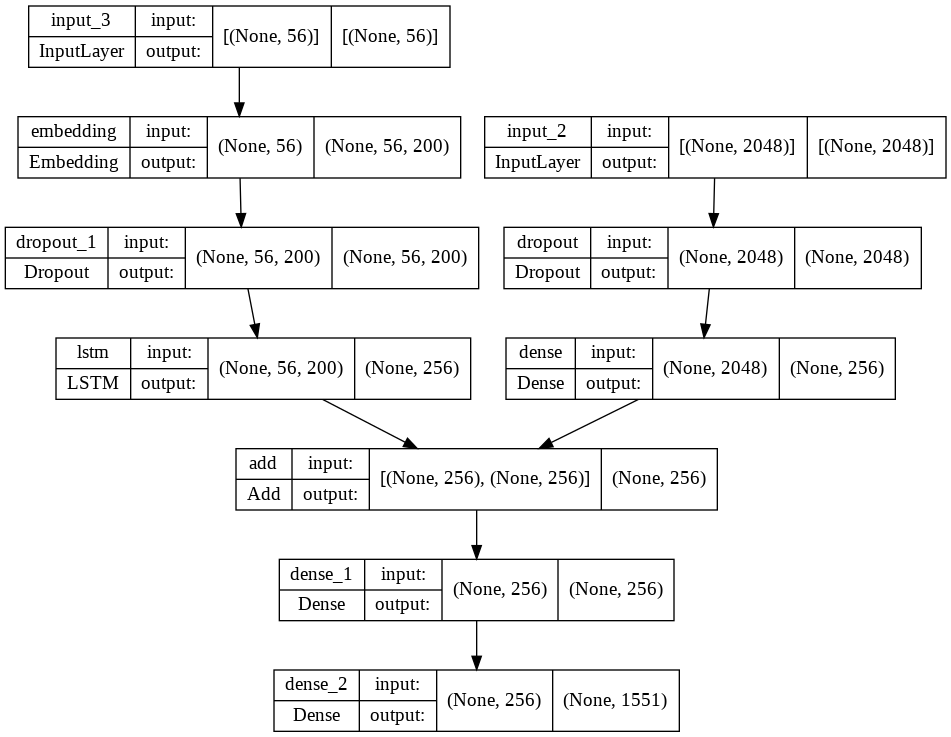

In [ ]:
 plot_model(model1, show_shapes=True)

In [73]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 56)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 56, 200)      310200      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [74]:
model1.layers[2]

In [75]:
model1.layers[2].set_weights([glove_matrix])
model1.layers[2].trainable = False

In [78]:
mod1_cb1= ModelCheckpoint(filepath='/content/drive/MyDrive/Project Data/mod1_cb1',save_weights_only=True,verbose=1)

In [80]:
for i in range(20):
    index_train_list = list(train.index.values) 
    train_iterator = iter(index_train_list)
    index_val_list = list(val.index.values) 
    val_iterator = iter(index_val_list)
    index_test_list = list(test.index.values) 
    test_iterator = iter(index_test_list)
    batch_size = 32
    opt_length = 56
    steps = len(train) // batch_size
    train_generator = batch_generator(df5,batch_size,index_train_list,docket,train_iterator,opt_length,corpus)
    val_generator = batch_generator(df5,batch_size,index_val_list,docket,val_iterator,opt_length,corpus)
    model1.fit(train_generator, epochs=1,steps_per_epoch = 84,verbose=1,validation_data = val_generator, validation_steps =12, callbacks = [mod1_cb1])


84/84 [==============================] - ETA: 0s - loss: 4.8057
Epoch 1: saving model to /content/drive/MyDrive/Project Data/mod1_cb1
84/84 [==============================] - ETA: 0s - loss: 4.5490
Epoch 1: saving model to /content/drive/MyDrive/Project Data/mod1_cb1
84/84 [==============================] - ETA: 0s - loss: 4.3687
Epoch 1: saving model to /content/drive/MyDrive/Project Data/mod1_cb1
84/84 [==============================] - ETA: 0s - loss: 4.2360
Epoch 1: saving model to /content/drive/MyDrive/Project Data/mod1_cb1
84/84 [==============================] - ETA: 0s - loss: 4.1212
Epoch 1: saving model to /content/drive/MyDrive/Project Data/mod1_cb1
84/84 [==============================] - ETA: 0s - loss: 4.0172
Epoch 1: saving model to /content/drive/MyDrive/Project Data/mod1_cb1
84/84 [==============================] - ETA: 0s - loss: 3.9225
Epoch 1: saving model to /content/drive/MyDrive/Project Data/mod1_cb1
84/84 [==============================] - ETA: 0s - loss: 3.837

In [ ]:
train_batch = batch_generator(df5,batch_size,train_iterator,opt_length,corpus)
len(train_batch)

2

In [ ]:
a = next(train_iterator)
print(a)

1991
